<a href="https://colab.research.google.com/github/TLG442/Research_Project/blob/feature%2Felectricity-consumption-prediction-model%2Fit21222740/Smart_Meter_Electricity_Consumption_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pythonafroz_electricity_smart_meter_data_from_india_path = kagglehub.dataset_download('pythonafroz/electricity-smart-meter-data-from-india')

print('Data source import complete.')


100%|██████████| 176M/176M [00:02<00:00, 80.4MB/s]

Extracting files...


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")# This Python 3 environment comes with many helpful analytics libraries installed

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
import os
import pandas as pd

# Assuming the dataset is stored in the path returned by kagglehub
dataset_path = pythonafroz_electricity_smart_meter_data_from_india_path

# List the files in the dataset directory
print(os.listdir(dataset_path))

# Load the CSV files
df_2020 = pd.read_csv(os.path.join(dataset_path, "CEEW - Smart meter data Bareilly 2020.csv"))
df_2021 = pd.read_csv(os.path.join(dataset_path, "CEEW - Smart meter data Bareilly 2021.csv"))

# Display the first few rows to ensure it's loaded correctly
print(df_2020.head())
print(df_2021.head())


['CEEW - Smart meter data Bareilly 2020.csv', 'SM Cleaned Data BR Aggregated.csv', 'CEEW - Smart meter data Bareilly 2021.csv', 'SM Cleaned Data MH Aggregated.csv', 'SM Cleaned Data BR2019.csv', 'SM Cleaned Data MH2021.csv', 'CEEW - Smart meter data Mathura 2019.csv', 'CEEW - Smart meter data Mathura 2020.csv']
           x_Timestamp  t_kWh  z_Avg Voltage (Volt)  z_Avg Current (Amp)  \
0  2020-01-01 00:00:00  0.002                251.26                 0.15   
1  2020-01-01 00:03:00  0.001                251.23                 0.15   
2  2020-01-01 00:06:00  0.001                251.55                 0.14   
3  2020-01-01 00:09:00  0.001                251.97                 0.14   
4  2020-01-01 00:12:00  0.002                252.03                 0.14   

   y_Freq (Hz) meter  
0        49.97  BR02  
1        49.94  BR02  
2        49.94  BR02  
3        50.09  BR02  
4        50.08  BR02  
           x_Timestamp  t_kWh  z_Avg Voltage (Volt)  z_Avg Current (Amp)  \
0  2021-01-02 00

In [5]:
from IPython.core.display import display, HTML
display(HTML('<h2 style="color:Blue"> <b> Smart Meter Data Bareilly 2020 </b> </h2> '))

display(df_2020.shape)
display(df_2020.head())

from IPython.core.display import display, HTML
display(HTML('<h2 style="color:Blue"> <b> Smart Meter Data Bareilly 2021 </b> </h2> '))

display(df_2021.shape)
df_2021.head()

(6627360, 6)

,x_Timestamp,t_kWh,z_Avg Voltage (Volt),z_Avg Current (Amp),y_Freq (Hz),meter
0,2020-01-01 00:00:00,0.002,251.26,0.15,49.97,BR02
1,2020-01-01 00:03:00,0.001,251.23,0.15,49.94,BR02
2,2020-01-01 00:06:00,0.001,251.55,0.14,49.94,BR02
3,2020-01-01 00:09:00,0.001,251.97,0.14,50.09,BR02
4,2020-01-01 00:12:00,0.002,252.03,0.14,50.08,BR02


(3948960, 6)

,x_Timestamp,t_kWh,z_Avg Voltage (Volt),z_Avg Current (Amp),y_Freq (Hz),meter
0,2021-01-02 00:00:00,0.002,253.36,0.25,50.09,BR02
1,2021-01-02 00:03:00,0.002,253.87,0.25,50.11,BR02
2,2021-01-02 00:06:00,0.020,253.25,1.67,50.14,BR02
3,2021-01-02 00:09:00,0.045,252.20,3.52,50.12,BR02
4,2021-01-02 00:12:00,0.044,252.28,3.53,50.07,BR02


In [6]:
import numpy as np
import pandas as pd

# Choose the appropriate DataFrame: df_2020 or df_2021
df = df_2020  # Or df = df_2021, depending on which data you want to use
df = df_2020.sample(frac=0.01, random_state=42)

# Assuming df is your DataFrame after parsing and preprocessing
# We focus on the `t_kWh` column for prediction
data = df[['t_kWh']].values

# Define the fraction of data to be used for training
train_fraction = 0.8  # This is 80% for training, adjust if needed

# Calculate the split index
split_index = int(len(data) * train_fraction)

# Split the data into training and testing sets
train_data, test_data = data[:split_index], data[split_index:]

# Print the shapes of train and test sets for verification
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")


Training data shape: (53019, 1)
Testing data shape: (13255, 1)


In [7]:

# Scale the data (MinMax scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Function to create sequences for the LSTM
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Set the sequence length (e.g., 60 timesteps)
sequence_length = 60

# Create training sequences
X_train, y_train = create_sequences(scaled_train_data, sequence_length)

# Create test sequences
X_test, y_test = create_sequences(scaled_test_data, sequence_length)

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (52959, 60, 1)
Test set shape: (13195, 60, 1)


In [18]:
X_train[1]

array([[0.04098361],
       [0.        ],
       [0.03688525],
       [0.33606557],
       [0.        ],
       [0.08606557],
       [0.38114754],
       [0.00819672],
       [0.00409836],
       [0.02459016],
       [0.11065574],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01229508],
       [0.        ],
       [0.02459016],
       [0.        ],
       [0.15163934],
       [0.4795082 ],
       [0.00819672],
       [0.09836066],
       [0.21311475],
       [0.0204918 ],
       [0.02868852],
       [0.02868852],
       [0.00819672],
       [0.09016393],
       [0.00819672],
       [0.0204918 ],
       [0.        ],
       [0.01229508],
       [0.        ],
       [0.06967213],
       [0.21311475],
       [0.00409836],
       [0.24590164],
       [0.04918033],
       [0.06557377],
       [0.        ],
       [0.04098361],
       [0.13934426],
       [0.11065574],
       [0.02868852],
       [0.08196721],
       [0.        ],
       [0.04508197],
       [0.028

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Build the LSTM Model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Batch Normalization

model.add(LSTM(units=50, return_sequences=False))
model.add(BatchNormalization())

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add Dense output layer
model.add(Dense(units=1))  # Predicting a single value (t_kWh)

# Step 2: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [12]:
# Step 3: Train the Model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,  # Adjust the number of epochs based on your needs
                    batch_size=32,
                    verbose=1)  # This enables full details of each epoch


Epoch 1/5
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 2/5
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 3/5
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 4/5
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 5/5
1655/1655 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0100 - val_loss: 0.0099


In [13]:

# Step 4: Evaluate the Model
# Evaluate the performance on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0099
Test Loss: 0.009929749183356762


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predictions:  [[0.01755651]
 [0.01755522]
 [0.01755577]
 [0.01755599]
 [0.01755473]]
Actual values:  [[0.004]
 [0.016]
 [0.014]
 [0.   ]
 [0.005]]


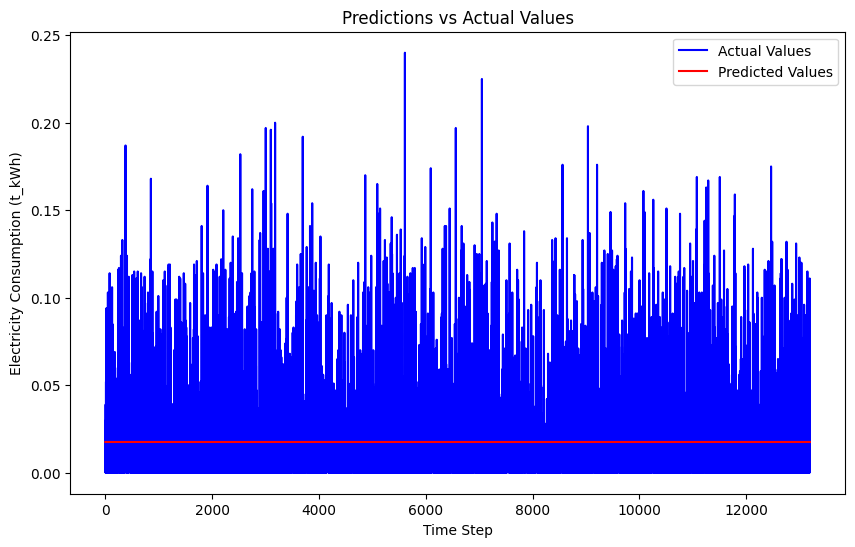

In [14]:
# Step 5: Make Predictions
# Let's predict the values for the test set
predictions = model.predict(X_test)

# Since we scaled the data, we need to inverse the scaling to get the original values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print a few predictions and actual values for comparison
print("Predictions: ", predictions[:5])
print("Actual values: ", y_test_actual[:5])

# Optionally, plot the predicted vs actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Actual Values')
plt.plot(predictions, color='red', label='Predicted Values')
plt.title("Predictions vs Actual Values")
plt.xlabel("Time Step")
plt.ylabel("Electricity Consumption (t_kWh)")
plt.legend()
plt.show()


In [15]:
# Single sequence (e.g., last 60 time steps of data) for prediction
sample_input_for_prediction = np.random.rand(1, 60, 1)  # 1 sequence, 60 timesteps, 1 feature

# Predict the next value
predicted_value = model.predict(sample_input_for_prediction)

# Inverse transform to get the actual value
predicted_value_actual = scaler.inverse_transform(predicted_value)

print("Predicted value:", predicted_value_actual)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted value: [[0.0175855]]


In [20]:
# The input sequence you provided
input_sequence = np.array([
    [0.04098361],
    [0.        ],
    [0.03688525],
    [0.33606557],
    [0.        ],
    [0.08606557],
    [0.38114754],
    [0.00819672],
    [0.00409836],
    [0.02459016],
    [0.11065574],
    [0.        ],
    [0.        ],
    [0.        ],
    [0.01229508],
    [0.        ],
    [0.02459016],
    [0.        ],
    [0.15163934],
    [0.4795082 ],
    [0.00819672],
    [0.09836066],
    [0.21311475],
    [0.0204918 ],
    [0.02868852],
    [0.02868852],
    [0.00819672],
    [0.09016393],
    [0.00819672],
    [0.0204918 ],
    [0.        ],
    [0.01229508],
    [0.        ],
    [0.06967213],
    [0.21311475],
    [0.00409836],
    [0.24590164],
    [0.04918033],
    [0.06557377],
    [0.        ],
    [0.04098361],
    [0.13934426],
    [0.11065574],
    [0.02868852],
    [0.08196721],
    [0.        ],
    [0.04508197],
    [0.02868852],
    [0.09836066],
    [0.08196721],
    [0.        ],
    [0.01639344],
    [0.12704918],
    [0.05737705],
    [0.01229508],
    [0.01639344],
    [0.06967213],
    [0.13934426],
    [0.        ],
    [0.00819672]
])

# Reshape the input sequence to match the LSTM input shape
input_sequence = input_sequence.reshape((1, 60, 1))  # 1 sample, 60 time steps, 1 feature

# Predict the next value using the trained model
predicted_value = model.predict(input_sequence)

# The predicted value is in the scaled range. Inverse the scaling to get the actual value.
predicted_value_actual = scaler.inverse_transform(predicted_value)

# Output the prediction
print(f"Predicted next t_kWh value: {predicted_value_actual[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted next t_kWh value: 0.017551932483911514


In [27]:
# Save the model in the new Keras format
model.save('smart_meter_model.keras')
